<a href="https://colab.research.google.com/github/AC8151/COG_INTERNSHIP_GN22CDBDS001/blob/main/SARIMAX_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SARIMAX Model - Superstore Data Analysis

#1. Obtaining dataset

In [1]:
!wget https://community.tableau.com/docs/DOC-1236

--2022-04-06 12:15:59--  https://community.tableau.com/docs/DOC-1236
Resolving community.tableau.com (community.tableau.com)... 13.109.212.160
Connecting to community.tableau.com (community.tableau.com)|13.109.212.160|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://community.tableau.com/s/question/0D54T00000CWeX8SAL [following]
--2022-04-06 12:15:59--  https://community.tableau.com/s/question/0D54T00000CWeX8SAL
Reusing existing connection to community.tableau.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls [following]
--2022-04-06 12:16:00--  https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls
Reusing existing connection to community.tableau.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘DOC-1236.1’

DOC-1236.1         

In [2]:
# data from https://community.tableau.com/docs/DOC-1236
!ls

 DOC-1236     sample_data		        superstore.xls
 DOC-1236.1  'Sample-Superstore.xls?raw=true'


> **xlrd => Excel Read**. <br>To read spreadsheets

In [3]:
!pip install pandas==1.2.0
!pip install --upgrade xlrd

#2. Reading Dataset and Storing in variable df

In [28]:
import pandas as pd
df = pd.read_excel('superstore.xls')
df.head()
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

#3. Importing Necessary Libraries

In [5]:
import warnings
import itertools
import numpy as np
import statsmodels.api as sm # for plotting decomposition graphs
import matplotlib.pyplot as plt # for plotting graphs
import matplotlib
%matplotlib inline # graphs displayed inline with code (not on a separate window)

warnings.filterwarnings("ignore")
# for production use, we may want to supress the warning

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#4. Analysing the Data

In [29]:
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [31]:
colNames = df.columns 
for i, feature in enumerate(colNames):
  print(colNames[i] + " " + str(len(df[feature].value_counts())))

Row ID 9994
Order ID 5009
Order Date 1237
Ship Date 1334
Ship Mode 4
Customer ID 793
Customer Name 793
Segment 3
Country 1
City 531
State 49
Postal Code 631
Region 4
Product ID 1862
Category 3
Sub-Category 17
Product Name 1850
Sales 6144
Quantity 14
Discount 12
Profit 7545


**EXPLANATION:**

> columns Sales, Quantity, Discount, Profit can be chosen for continuous data but Quantity, Discount appear to be DISCRETE (less values) now Profit is more varied than Sales, as it depends on Discount

<br> ***Therefore, we consider Sales as the continuous data, on which we will create a time-series analysis***

In [33]:
data = df.loc[df['Category']=='Furniture']  # LOC-> :,:
#data.head()
print(data['Order Date'].min())
print(data['Order Date'].max())

2014-01-06 00:00:00
2017-12-30 00:00:00


In [39]:
df = data.groupby('Order Date')
indata = df['Order Date'].value_counts().count()
actual = 4*365.25
print('No.of days in our data:', indata)
print('Actual No.of days should be: ', actual)
print('Missing No. of days: ', actual-indata)

No.of days in our data: 889
Actual No.of days should be:  1461.0
Missing No. of days:  572.0


#5. Create a Time-Series Analysis Dataframe
Using Order Date and Sales columns
> To find the trend in Sales based on Order Dates

In [42]:
data_grouped = data.groupby('Order Date')
data_grouped = data_grouped['Sales'].sum().reset_index()
data_grouped.tail()

,Order Date,Sales
884,2017-12-24,1393.4940
885,2017-12-25,832.4540
886,2017-12-28,551.2568
887,2017-12-29,2330.7180
888,2017-12-30,323.1360


##5.1. Resampling Order Date
To fill missing dates

In [15]:
data_grouped.set_index('Order Date', inplace=True)
y = data_grouped['Sales'].resample('MS').mean()
y.head()


Order Date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: Sales, dtype: float64

**EXPLANATION:**

Resampling is done by MONTH (MS) because
1. Resampling by 1D or 1W leads to more repeated values
2. Resampling by 1A (year) leads to less accurate dates

***Each month has different no. of days => resampled by avg. dates***

In [43]:
## Sales between 2014 and 2015
# To check how well the resampling has worked
y.tail()
y['2014':'2015']


Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049187
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

##5.2. Visualizing Sales Trend over Order Date (Time)

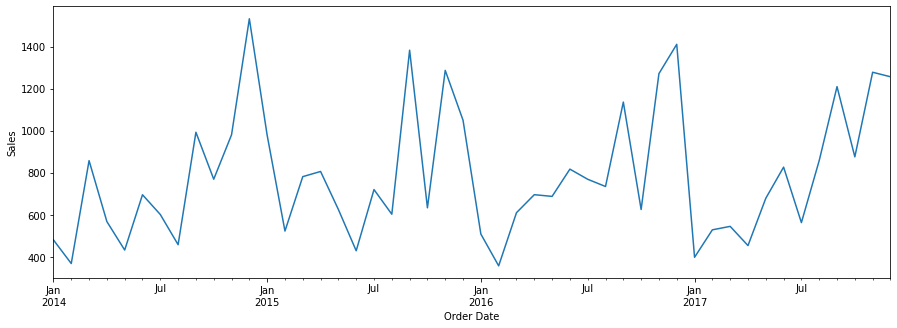

In [47]:
plt.figure()
y.plot(figsize=(15,5))
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.show()


##5.3. Visualizing Decomposed Graph to understand Seasonal Trend

**EXPLANATION:**

There is a need to visualize these observations above properly.
Thus, we DECOMPOSE the graph into 3 to view ***TREND, SEASONAL TREND (PATTERN), NOISE (EXTRA)***

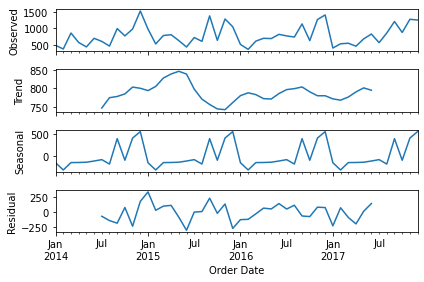

In [45]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show() 

**OBSERVATION:**

1. Sales trend is POSITIVE
2. Sales INCREASES FROM JULY-DEC (FESTIVE)
3. Sales LESS FROM JAN-JUNE (MONEY SPENT)

#6. Building A SARIMAX Model for Forecasting Sales

2 algorithms to build these truth tables:

1) EXHAUSTIVE -> ALL COMBINATIONS (entire truth table will be created)

- SLOWER

-> GRID SEARCH 

2) Not the best, but workable answer (randomly truth will be created)

- FASTER 

-> RANDOM SEARCH 

https://towardsdatascience.com/random-search-vs-grid-search-for-hyperparameter-optimization-345e1422899d


Can be used to find best combination(s) of algo comparison, parameters, hyperparameters, metrics or wherever TOO many are present and we could select a few of them! 

**EXPLANATION:**

In non-seasonal ARIMA:<br>
1. **p** = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series
<br>
2. **d** = D refers to the number of differencing transformations required by the time series to get stationary (series where mean and variance are constant over time.)
<br>
3. **q** = This variable denotes the lag of the error component (NOISE), where error component is a part of the time series not explained by trend or seasonality

##6.1. pdq values (ARIMA)

In [48]:
# in AR I MA -> p,d,q 
p = d = q = range(0,2) # VALUE generators between [0,1] 
pdq = list(itertools.product(p,d,q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


**EXPLANATION:**

For seasonal ARIMA (SARIMA), we need take the number of periods in a season into consideration too!
<br>
4. **m** = 12 (months in 1 year)

##6.2. spdq values (SARIMAX)

In [49]:
seasons = 12 
# repeatation of seasonal trend every 12 months
# LIST COMPREHENSION -> (0,0,0) -> (0,0,0,12)
seasonal_pdq = [   (x[0],x[1],x[2], seasons)  for x in pdq] # if x was (0,1,0), -> (0,1,0,12)
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[0]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[1]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[2]))
print('SARIMAX individual MODEL = {} X {}'.format(pdq[5], seasonal_pdq[3]))
# here is an INDIVIDUAL MODEL -> WITH and WITHOUT SEASON 
# ALL SUCH PERMUTATIONS WILL BE EXHAUSTIVELY CREATED!!! 
# EVERY POSSIBLE COMBINATION HAS BEEN CREATED! 
# AN SARIMAX -> SEASONAL ARIMA EXHAUSTIVE 
# ALL possible algos with (seasonal_pdq) and without season (pdq)


SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 0, 1, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 0, 12)
SARIMAX individual MODEL = (1, 0, 1) X (0, 1, 1, 12)


##6.3. Finding all possible combinations of pdq and spdq values: Determine the BEST (AIC)

**EXPLANATION:**

>To determine which model is better, AIC test is used as criterion.
AIC:<br>
1. Evaluates the goodness of the fit while punishing non-parsimonious models (that require many no. of parameters to explain data) in order to prevent overfitting.
2. Model with least AIC score => ***BEST!***

In [21]:
min_pdq = (999,999,999)
min_spdq = (999,999,999,12)
min_AIC = 999
for param in pdq:
  for sparam in seasonal_pdq:
    try:
      model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=sparam, enforce_stationarity=False)
      predictions = model.fit()
      print('Model={}X{}. AIC= {}'.format(param, sparam, predictions.aic))
      if(predictions.aic < min_AIC):
        min_pdq = param
        min_spdq = sparam
        min_AIC = predictions.aic
    except Exception as e:
      print(e)
      continue

print('**** Smallest PDQ,SPDQ is *****')
print(min_AIC)
print(min_pdq)
print(min_spdq)


Model=(0, 0, 0)X(0, 0, 0, 12). AIC= 769.0817523205916
Model=(0, 0, 0)X(0, 0, 1, 12). AIC= 548.1772347587046
Model=(0, 0, 0)X(0, 1, 0, 12). AIC= 477.71701309202774
maxlag should be < nobs
Model=(0, 0, 0)X(1, 0, 0, 12). AIC= 497.2314433418337
Model=(0, 0, 0)X(1, 0, 1, 12). AIC= 478.3653805749645
Model=(0, 0, 0)X(1, 1, 0, 12). AIC= 318.0047199116341
maxlag should be < nobs
Model=(0, 0, 1)X(0, 0, 0, 12). AIC= 720.9252270739973
Model=(0, 0, 1)X(0, 0, 1, 12). AIC= 514.7587049639892
Model=(0, 0, 1)X(0, 1, 0, 12). AIC= 466.5556513479083
maxlag should be < nobs
Model=(0, 0, 1)X(1, 0, 0, 12). AIC= 498.8314925544705
Model=(0, 0, 1)X(1, 0, 1, 12). AIC= 467.1039211192387
Model=(0, 0, 1)X(1, 1, 0, 12). AIC= 319.9884876946219
maxlag should be < nobs
Model=(0, 1, 0)X(0, 0, 0, 12). AIC= 677.894766859465
Model=(0, 1, 0)X(0, 0, 1, 12). AIC= 488.7012043020711
Model=(0, 1, 0)X(0, 1, 0, 12). AIC= 486.63785671879367
maxlag should be < nobs
Model=(0, 1, 0)X(1, 0, 0, 12). AIC= 497.78896630044073
Model=(0, 1, 0

##6.4. Building SARIMAX Models to compare Sales Forecasting

**EXPLANATION:**

**MODEL - Selecting the minimum pdq and spdq combinations => because of AIC**<BR>
**MODEL2 - Selecting a random pdq and spdq combination** (for comparing the performance of actual proper model and model2

In [51]:
model = sm.tsa.statespace.SARIMAX(y, order=min_pdq, seasonal_order= min_spdq, enforce_stationarity=False)
# (0, 1, 0)X(1, 0, 1, 12)
model2 = sm.tsa.statespace.SARIMAX(y, order=(0, 1, 0), seasonal_order= (1, 0, 1, 12), enforce_stationarity=False)
results = model.fit()
results2 = model2.fit()
# we've taken 2 models so that we can compare their predictions 
results.summary() #.tables[1]  # AIC => needs to be lowest 
# results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -145.301
Date:                            Wed, 06 Apr 2022   AIC                            298.602
Time:                                    13:20:37   BIC                            302.966
Sample:                                01-01-2014   HQIC                           299.630
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1280      0.276      0.464      0.643      -0.412       0.669
ma.L1         -0.9998      0.450     -2.223      0.026      -1.881      -0.118
ar.S.L12      -0.2811      0.154     -1.826      0.068      -0.583       0.021
sigma2      3.028e+04   1.49e-05   2.04e+09      0.000    3.03e+04    3.03e+04
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.77
Prob(Q):                               nan   Prob(JB):                         0.68
Heteroskedasticity (H):               0.67   Skew:                            -0.22
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.69e+24. Standard errors may be unstable.
"""

#7. Visualizing and understanding Forecasting Ability of SARIMAX models

**EXPLANATION:**

Checking forecasting ability of model with AIC approved pdq and spdq values

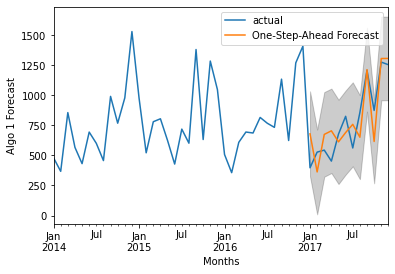

In [52]:
# let's check the actual predictions and plot them 

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
pred2 = results2.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred2_ci = pred2.conf_int()
ax = y['2014':].plot(label='actual') # ACTUAL DATA PLOT
pred.predicted_mean.plot(ax=ax, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
ax.set_xlabel('Months')
ax.set_ylabel('Algo 1 Forecast')
plt.legend()
plt.show() 



**EXPLANATION:**

Checking forecasting ability of model2 ( one with custom pdq and spdq values)





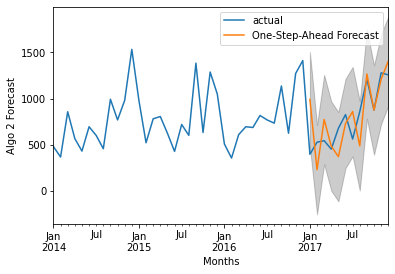

In [24]:
plt.figure()
bx = y['2014':].plot(label='actual') # ACTUAL DATA PLOT
pred2.predicted_mean.plot(ax=bx, label='One-Step-Ahead Forecast')
# there is always a tolerance or error kernel(region) surrounding the forecast
# +- region within which mistakes are acceptable 
# THIS TOLERANCE REGION is also called CONFIDENCE INTERVAL 
bx.fill_between(pred2_ci.index, pred2_ci.iloc[:,0], pred2_ci.iloc[:,1], color='k', alpha=0.2)
# BASE LINE-> index, lower confidence limit, upper confidence limit
bx.set_xlabel('Months')
bx.set_ylabel('Algo 2 Forecast')
plt.legend()
plt.show() 

#8. OBSERVATION

SARIMAX forecasting model with AIC approved pdq and spdq values is better in forecasting the sales trends over order date.